In [1]:
from PIL import Image
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
from functools import reduce
from random import randint
import math
from numba import jit, float32

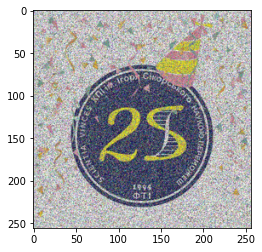

RGB
 img shape (256, 256, 3)


In [2]:
# Do not touch

# load the image
image = Image.open('ipt.png').resize((256, 256))
plt.imshow(image)
plt.show()

#print image mode
print(image.mode)

# convert image to numpy array (256, 256, 3)
img_tenzor = np.asarray(image)
shape = img_tenzor.shape[:2]
# summarize shape
print(f' img shape {img_tenzor.shape}')

### cut examples 2 for image segments

In [3]:
# #Do not need

# segment_1 = img_tenzor[:50, 30:80]
# segment_2 = img_tenzor[250:, 250:]

# plt.imshow(img_tenzor)
# plt.show()
# plt.imshow(segment_1, interpolation='nearest')
# plt.show()
# plt.imshow(segment_2, interpolation='nearest')
# plt.show()

In [4]:
# #Do not need

# segment_1 = np.concatenate((segment_1), axis=0 )
# segment_1_mean = segment_1.mean(axis=0)
# segment_1_cov = np.cov(segment_1, rowvar=False)

# print(f'segment_1 MEAN  \t{segment_1_mean}\n')
# print(f'segment_1 COV MATRIX\n {segment_1_cov}\n')
# print(f'segment_1 COV MATRIX shape \t {np.shape(segment_1_cov)}')

In [5]:
# #Do not need

# segment_2 = np.concatenate((segment_2), axis=0 )
# segment_2_mean = segment_2.mean(axis=0)
# segment_2_cov = np.cov(segment_2, rowvar=False)

# print(f'segment_2 MEAN  \t{segment_2_mean}\n')
# print(f'segment_2 COV MATRIX\n {segment_2_cov}\n')
# print(f'segment_2 COV MATRIX shape \t {np.shape(segment_2_cov)}')

In [6]:
mu1 = np.array([50,50,50], dtype=np.float64)
mu2 = np.array([200,170,200], dtype=np.float64)
cov1 = np.array([[10**2,2**2,2**2], [2**2, 10**2, 2**2],[2**2, 2**2, 10**2]], dtype=np.float64)
cov2 = np.array([[10**2,2**2,2**2], [2**2, 10**2, 2**2],[2**2, 2**2, 10**2]], dtype=np.float64)
print(type(cov1))

<class 'numpy.ndarray'>


In [7]:
K = 2
R = 3
S = 3

### For each pixel put initial segment type

In [8]:
@jit(nopython=True)        
def norm_pdf_multivariate(x, mu, sigma):
    size = len(x)
    if size == len(mu) and (size, size) == sigma.shape:
        det = np.linalg.det(sigma)
        if det == 0:
            raise NameError("The covariance matrix can't be singular")

        norm_const = 1.0/ (math.pow((2*math.pi),float(size)/2) * math.pow(det,1.0/2) )
        x_mu = x - mu
        inv = np.linalg.inv(sigma)         
        result = math.pow(math.e, -0.5 * ((x_mu).dot(inv).dot(x_mu.T)))
        return norm_const * result
    else:
        raise NameError("The dimensions of the input don't match")
        
        
        
@jit(nopython=True)
def likelyhood(pixel_color_list,  mu1, cov1, mu2, cov2):
    
    pdf_1 = norm_pdf_multivariate(pixel_color_list, mu1, cov1)
    pdf_2 = norm_pdf_multivariate(pixel_color_list,  mu2, cov2)
    
    return randint(0, 1), pdf_1, pdf_2  #marker color of 1 class and it's probability
    

print(likelyhood(img_tenzor[253][253], mu1, cov1, mu2, cov2))

(1, 4.469488132150066e-58, 1.4401987101281227e-20)


In [9]:
# marked_image_data  = np.zeros(shape=(*img_tenzor.shape[:2], 2), dtype=float)
# print(marked_image_data.shape)

# for i, j  in np.ndindex(img_tenzor.shape[:2]):
#     marked_image_data[i][j] = likelyhood(img_tenzor[i][j],  mu1, covar, mu2, covar)
    
# plt.imshow(marked_image_data[:, :, 0])
# plt.show()

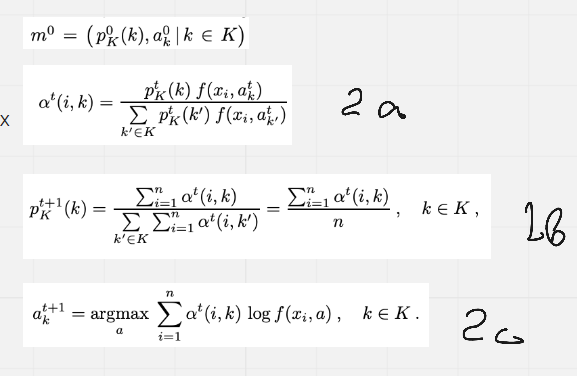

In [10]:
@jit(nopython=True)
def expectation(img_tenzor, p_k1, p_k2, mu1, mu2, cov1, cov2, shape):
    
    alpha_matrix  = np.zeros(shape=(*shape, 2), dtype=float32)
    pk_matrix = np.zeros(shape=(*shape, 2), dtype=float32)
    alpha_1_sum = 0
    alpha_2_sum = 0    
    for i in range(shape[0]):
        for j in range(shape[1]):
            _, like_1, like_2 = likelyhood(img_tenzor[i][j], mu1, cov1, mu2, cov2)
            numerator1, numerator2 = (p_k1*like_1), (p_k2*like_2)
            alpha_1, alpha_2 = numerator1/(numerator1+numerator2), numerator2/(numerator1+numerator2)
            alpha_matrix[i][j] = alpha_1, alpha_2
            alpha_1_sum += alpha_1
            alpha_2_sum += alpha_2
            p_k1 = alpha_1_sum/(shape[0]*shape[1])
            p_k2 = alpha_2_sum/(shape[0]*shape[1])
    #print(p_k1, p_k2)
#     print(alpha_matrix)    
    return alpha_matrix, alpha_1_sum, alpha_2_sum

In [11]:
@jit(nopython=True)
def maximization(img_tensor, alpha_matrix, alpha_1_sum, alpha_2_sum, mu1, mu2, cov1, cov2):
    for r in range(R):
        mu1[r] = np.sum(alpha_matrix[:, :, 0]*img_tenzor[:, :, r])/alpha_1_sum
        mu2[r] = np.sum(alpha_matrix[:, :, 1]*img_tenzor[:, :, r])/alpha_2_sum
        for s in range(S):
            cov1[r, s] = np.sum(alpha_matrix[:, :, 0]*(img_tenzor[:, :, r]-mu1[r])*(img_tenzor[:, :, s]-mu1[s]))/alpha_1_sum
            cov2[r, s] = np.sum(alpha_matrix[:, :, 1]*(img_tenzor[:, :, r]-mu2[r])*(img_tenzor[:, :, s]-mu2[s]))/alpha_2_sum
    return mu1, mu2, cov1, cov2

In [12]:
@jit(nopython=True)
def find_neighbors(matrix, i, j):
    neighbors = [matrix[i+step[0], j+step[1], 0] for step in
                      [(0,-1), (0,1), (-1,0), (1,0)] 
                    if ((0 <= i+step[0] < len(matrix)) and (0 <= j+step[1] < len(matrix[0])))]
    return neighbors

@jit(nopython=True)
def sampling(matrix, eps, shape):
    
    new_matrix = np.zeros(shape=shape, dtype=float32)
    for i in range(shape[0]):
        for j in range(shape[1]):
            neighbors = find_neighbors(matrix, i, j)
            k1 = matrix[i,j][1]*reduce(lambda a, b: a*b,[(1 - eps) if x == 1 else eps for x in neighbors])
            k2 = matrix[i,j][2]*reduce(lambda a, b: a*b,[(1 - eps) if x == 0 else eps for x in neighbors])
            prob_k1, prob_k2 = k1/(k1+k2), k2/(k1+k2)
            new_matrix[i,j,0] = (1 if prob_k1 > prob_k2 else 0)
            new_matrix[i,j,1:]= prob_k1, prob_k2
    return new_matrix

In [13]:
shape1 = img_tenzor.shape
shape1

(256, 256, 3)

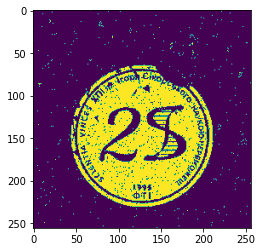

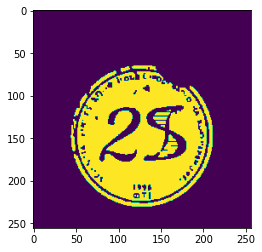

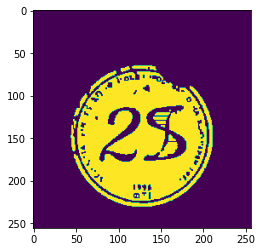

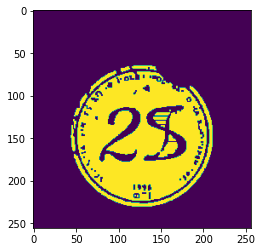

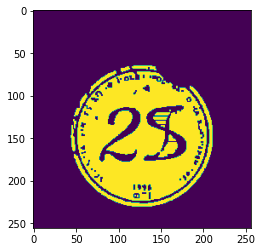

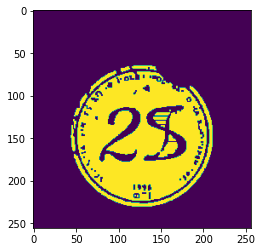

Wall time: 41.2 s


In [14]:
%%time
A = np.zeros(shape=(img_tenzor.shape), dtype=float)

p_k1 = 1/2.
p_k2 = 1/2.
for iteration in range(100):
    alpha_matrix, alpha_1_sum, alpha_2_sum = expectation(img_tenzor, p_k1, p_k2, mu1, mu2, cov1, cov2, shape)
    mu1, mu2, cov1, cov2 = maximization(img_tenzor, alpha_matrix, alpha_1_sum, alpha_2_sum, mu1, mu2, cov1, cov2)

for i in range(len(A)):
    for j in range(len(A[i])):
        A[i, j] = likelyhood(img_tenzor[i][j],  mu1, cov1, mu2, cov2)

for i in range(101):
    A = sampling(A, 0.2, shape1)
    if i % 20 == 0:
        plt.imshow(A[:, :, 0])
        plt.show()